In [1]:
%matplotlib inline
%pylab inline

from functools import wraps

import menpo.io as mio
from menpo.shape import PointCloud
from menpo.landmark import labeller, ibug_face_68, ibug_face_51
from menpo.model import PCAModel
from menpo.visualize import visualize_images

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Reconstruct 68 point shapes from 51 point ones

Import all images from the `LFPW` training dataset labelling their landmarks using the `ibug_face_66` and `ibug_face_49` labelling schemes.

In [2]:
images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', verbose=True):
    if i.n_channels == 3:
        i = i.crop_to_landmarks_proportion(0.5)
        i = i.rescale_landmarks_to_diagonal_range(200)
        labeller(i, 'PTS', ibug_face_51)
        labeller(i, 'PTS', ibug_face_68)
        images.append(i)

Importing assets: [==========] 100% (811/811) - done.                           


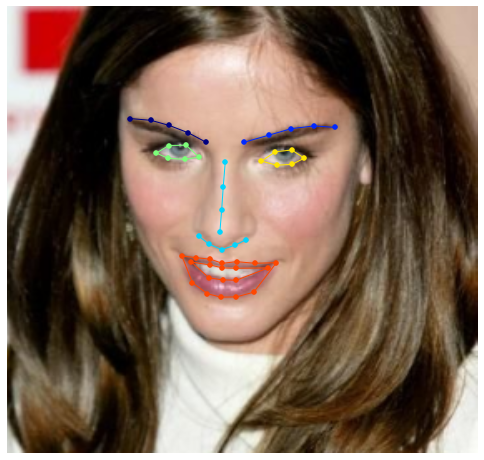

In [3]:
visualize_images(images)

Extract 66 and 49 points shapes:

In [4]:
shapes_68 = [image.landmarks['ibug_face_68'].lms for image in images] 
shapes_51 = [image.landmarks['ibug_face_51'].lms for image in images] 

Define the funtion `project_incomplete` and `weights_probability` and add them as a methods to the `PCAModel` class. These 2 methods will allow us to compute the most plausible set of model parameters given an incomplete shape (a shape with missing points) and to compute the probability of a given set of model weights (and, indirectly, of the shape intance associated to them) respectively:

In [5]:
# useful decorator
def adapt_input(wrapped):
    @wraps(wrapped)
    def wrapper(self, x, *args, **kwargs):
        if isinstance(x, PointCloud):
            z = x.as_vector()
        elif isinstance(x, list) and isinstance(x[0], PointCloud):
            z = [y.as_vector() for y in x]
            z = np.asarray(z)
        elif isinstance(x, np.ndarray) and len(x.shape) == 1:
            z = x[None, ...]
        elif isinstance(x, np.ndarray) and len(x.shape) == 2:
            z = x
        elif isinstance(x, list) and isinstance(x[0], np.ndarray) and len(x[0].shape) == 1:
            z = np.asarray(x)
        return wrapped(self, z, *args, **kwargs)
    return wrapper


# This is based on: http://www.miketipping.com/papers/met-mppca.pdf mainly Section 3.3
@adapt_input
def project_incomplete(self, incomplete_instance, indices):
    U = self.components[:, indices,]
    sigma2 = self.noise_variance()
    t = incomplete_instance
    m = self.mean_vector[indices]
    
    # \mathbf{M} = \sigma^2 \mathbf{I} + \mathbf{W}^T \mathbf{W}
    M = U.T.dot(U)
    np.fill_diagonal(M, self.noise_variance_ratio() + np.diag(M))
    
    # \mathbf{P} = \mathbf{M}^{-1} \mathbf{W}^T 
    P = np.linalg.solve(M, U.T)
    
    # \mathbf{x} = \mathbf{P} (\mathbf{t} - \mathbf{m})
    return (t - m).dot(P)


# This is based on: http://www.face-rec.org/algorithms/AAM/app_models.pdf Section 4.6
def probability(self, weights):
    n_weights = weights.shape[0]
    return np.exp(-0.5 * np.sum(weights**2 / self.eigenvalues[:n_weights], axis=1))


# Add both methods to the standard PCAModel menpo class
PCAModel.project_incomplete = project_incomplete
PCAModel.probability = probability

Build a shape model using the shapes containing 68 points:

In [6]:
pdm = PCAModel(shapes_68)

Keep 98% of the total variance. This is a free parameter that we can tune.

In [7]:
# keep 98% of the model's variance
pdm.n_active_components = 0.98

print 'number of model components being used:', pdm.n_active_components

number of model components being used: 9


In this short example we will attempt to reconstruct the previous 68 point shapes from the 51 point ones. 

In this cell, I specify the correspondance between the previous 68 and 51 points (note that points are 2 dimensional and are vectorized: 

$$\mathbf{s} = (\mathbf{p}_1, \mathbf{p}_2, \cdots, \mathbf{p}_n)^T = (y_1, x_1, y_2, x_2, \cdots, y_n, x_n)^T$$ 

and hence, in this case, `indices` go up to 135 = 68 * 2 - 1.

In [8]:
indices = range(17*2, 68*2)

print indices

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135]


We are now ready to perform the reconstructions:

In [9]:
weights = pdm.project_incomplete(shapes_51, indices)

for (w, image) in zip(weights, images):
    image.landmarks['plausible'] = pdm.instance(w)

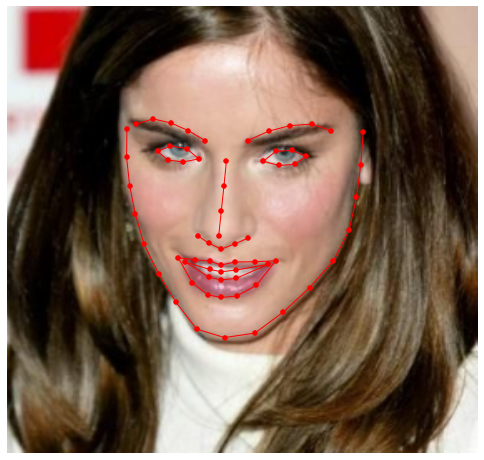

In [10]:
# to visualize the reconstructions select the Landmarks tab and set `plausible` as a group
visualize_images(images)

And to compute the probability of the reconstructed shapes:

In [11]:
probabilities = pdm.probability(weights)

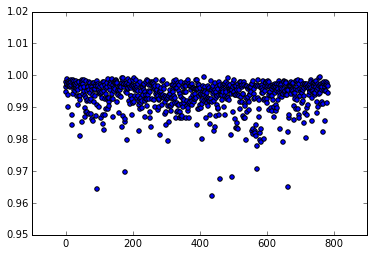

In [12]:
scatter(range(len(probabilities)), probabilities)